In [ ]:
'''
Chose any universe of stocks (Large cap, mid cap, small cap, Industry specific,
factor specific etc.) and stick to this group of stock as the source for your 
portfolio for the entire duration of backtesting.

Build fixed individual position sized long only portfolio by picking m number of
stocks based on monthly returns (or any other suitable criterion).

Rebalance the portfolio every month by removing worse x stocks and replacing them
with top x stocks from the universe of stocks (can existing stock be picked
again?)

Backtest the strategy and compare the KPIs with that of simple buy and hold strategy of
corresponding index.

'''

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import copy
import matplotlib.pyplot as plt

In [2]:
#Import the KPIs functions that we'll use

def CAGR(DF): #Notice it's been changed to monthly (thus, the 12). Besides, a column in DF is needed with the mon_ret
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):  #Notice it's been changed to monthly (thus, the sqrt(12))
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(12)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [3]:
# Download historical data (monthly) for DJI constituent stocks

tickers = ["MMM","AXP","T","BA","CAT","CVX","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UTX","UNH","VZ","V","WMT","DIS"] # Constituents of dow jones as of 2014-02-01 (except dow chemicals because Yahoo didn't have all the data)

ohlc_mon = {} # directory with ohlc value for each stock            
attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] # removing stocks whose data has been extracted from the ticker list
    for i in range(len(tickers)):
        try:
            ohlc_mon[tickers[i]] = pdr.get_data_yahoo(tickers[i],datetime.date.today()-datetime.timedelta(2419),datetime.date.today(),interval='m')  
            ohlc_mon[tickers[i]].dropna(inplace = True)
            drop.append(tickers[i])       
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data


UTX  :failed to fetch data...retrying
UTX  :failed to fetch data...retrying
UTX  :failed to fetch data...retrying
UTX  :failed to fetch data...retrying
UTX  :failed to fetch data...retrying
UTX  :failed to fetch data...retrying


In [4]:
################################Backtesting####################################

# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon) #deep copy to make sure any changes in the dictionary doesn't affect the original
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]

# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0] #Init a list with the returns of every month (first on is always 0)
    for i in range(1,len(df)): #For every month 
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean()) #df[portfolio].iloc[i,:] is a series object with the tickers in portfolio as index and the ith monthly returns as their values. Then we average that
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist() #sort_values(ascending=True)[:x] takes the first x stocks in df[portfolio].iloc[i,:]. .index gets the index of those. .tolist() saves those stock's tickers as a list
            portfolio = [t for t in portfolio if t not in bad_stocks] #Remove those bad_stocks from portfolio
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:x].index.values.tolist() #Get the new stocks x we are gonna introduce in our portfolio. Notice we are allowing the position of a stock to double or triple by allowing this new_picks to contain the 3 best stock returns. For example if we already have MSFT and it performs the best of the whole DJ for 2 months, we'll end up with MSFT position tripled in our portfolio
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

calculating monthly return for  MMM
calculating monthly return for  AXP
calculating monthly return for  T
calculating monthly return for  BA
calculating monthly return for  CAT
calculating monthly return for  CVX
calculating monthly return for  CSCO
calculating monthly return for  KO
calculating monthly return for  XOM
calculating monthly return for  GE
calculating monthly return for  GS
calculating monthly return for  HD
calculating monthly return for  IBM
calculating monthly return for  INTC
calculating monthly return for  JNJ
calculating monthly return for  JPM
calculating monthly return for  MCD
calculating monthly return for  MRK
calculating monthly return for  MSFT
calculating monthly return for  NKE
calculating monthly return for  PFE
calculating monthly return for  PG
calculating monthly return for  TRV
calculating monthly return for  UNH
calculating monthly return for  VZ
calculating monthly return for  V
calculating monthly return for  WMT
calculating monthly return for  DIS


In [5]:
#calculating overall strategy's KPIs
CAGR(pflio(return_df,6,3))
sharpe(pflio(return_df,6,3),0.025)
max_dd(pflio(return_df,6,3)) 

#calculating KPIs for Index buy and hold strategy over the same period
DJI = pdr.get_data_yahoo("^DJI",datetime.date.today()-datetime.timedelta(2419),datetime.date.today(),interval='m')
DJI["mon_ret"] = DJI["Adj Close"].pct_change()
CAGR(DJI)
sharpe(DJI,0.025)
max_dd(DJI)

['PG', 'UNH', 'MCD']
['WMT', 'VZ', 'T']
['CSCO', 'CAT', 'IBM']
['IBM', 'CVX', 'CAT']
['PFE', 'CVX', 'JPM']
['CSCO', 'MSFT', 'PFE']
['T', 'VZ', 'JNJ']
['MSFT', 'CAT', 'HD']
['MRK', 'GS', 'JPM']
['CAT', 'INTC', 'CVX']
['GS', 'BA', 'MSFT']
['GS', 'JPM', 'CAT']
['T', 'GS', 'TRV']
['DIS', 'MRK', 'V']
['CSCO', 'BA', 'GS']
['MSFT', 'MMM', 'DIS']
['CAT', 'MCD', 'UNH']
['MCD', 'KO', 'WMT']
['NKE', 'JPM', 'AXP']
['BA', 'VZ', 'V']
['V', 'CAT', 'UNH']
['CVX', 'HD', 'INTC']
['INTC', 'WMT', 'MSFT']
['WMT', 'CSCO', 'T']
['CAT', 'BA', 'T']
['BA', 'TRV', 'MSFT']
['CSCO', 'INTC', 'BA']
['INTC', 'CVX', 'PG']
['UNH', 'CVX', 'MRK']
['INTC', 'CAT', 'MSFT']
['NKE', 'PG', 'VZ']
['JPM', 'PFE', 'MRK']
['CSCO', 'WMT', 'V']
['CAT', 'BA', 'XOM']
['VZ', 'WMT', 'PG']
['CAT', 'AXP', 'MMM']
['GE', 'NKE', 'PG']
['GE', 'BA', 'GS']
['BA', 'INTC', 'CSCO']
['MSFT', 'V', 'PG']
['DIS', 'JPM', 'MSFT']
['UNH', 'PFE', 'TRV']
['CAT', 'GS', 'GE']
['PG', 'GS', 'IBM']
['BA', 'HD', 'VZ']
['NKE', 'INTC', 'IBM']
['UNH', 'GE', 'INTC']


0.23201266165063406

['PG', 'UNH', 'MCD']
['WMT', 'VZ', 'T']
['CSCO', 'CAT', 'IBM']
['IBM', 'CVX', 'CAT']
['PFE', 'CVX', 'JPM']
['CSCO', 'MSFT', 'PFE']
['T', 'VZ', 'JNJ']
['MSFT', 'CAT', 'HD']
['MRK', 'GS', 'JPM']
['CAT', 'INTC', 'CVX']
['GS', 'BA', 'MSFT']
['GS', 'JPM', 'CAT']
['T', 'GS', 'TRV']
['DIS', 'MRK', 'V']
['CSCO', 'BA', 'GS']
['MSFT', 'MMM', 'DIS']
['CAT', 'MCD', 'UNH']
['MCD', 'KO', 'WMT']
['NKE', 'JPM', 'AXP']
['BA', 'VZ', 'V']
['V', 'CAT', 'UNH']
['CVX', 'HD', 'INTC']
['INTC', 'WMT', 'MSFT']
['WMT', 'CSCO', 'T']
['CAT', 'BA', 'T']
['BA', 'TRV', 'MSFT']
['CSCO', 'INTC', 'BA']
['INTC', 'CVX', 'PG']
['UNH', 'CVX', 'MRK']
['INTC', 'CAT', 'MSFT']
['NKE', 'PG', 'VZ']
['JPM', 'PFE', 'MRK']
['CSCO', 'WMT', 'V']
['CAT', 'BA', 'XOM']
['VZ', 'WMT', 'PG']
['CAT', 'AXP', 'MMM']
['GE', 'NKE', 'PG']
['GE', 'BA', 'GS']
['BA', 'INTC', 'CSCO']
['MSFT', 'V', 'PG']
['DIS', 'JPM', 'MSFT']
['UNH', 'PFE', 'TRV']
['CAT', 'GS', 'GE']
['PG', 'GS', 'IBM']
['BA', 'HD', 'VZ']
['NKE', 'INTC', 'IBM']
['UNH', 'GE', 'INTC']


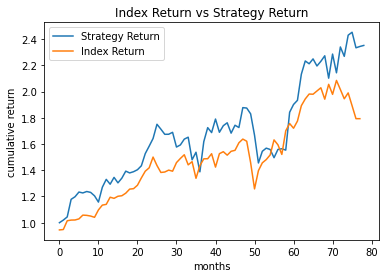

In [6]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"][2:].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])